In [9]:


from datasets import load_dataset
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, ConcatDataset
from torchvision import transforms
import pytorch_lightning as pl
from PIL import Image
import timm
import torch.nn.functional as F

In [2]:
# Load datasets
afhq_dataset = load_dataset("bitmind/AFHQ")
afhq_realvisxl_dataset = load_dataset("bitmind/AFHQ___RealVisXL_V4.0")


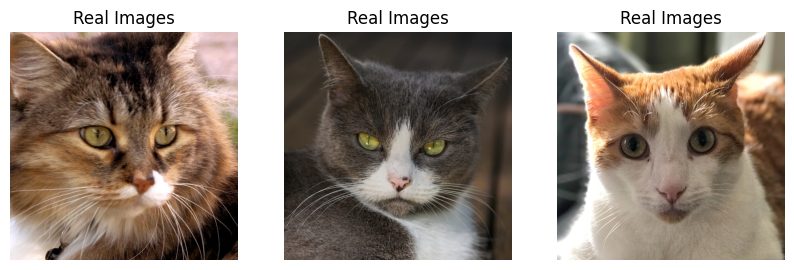

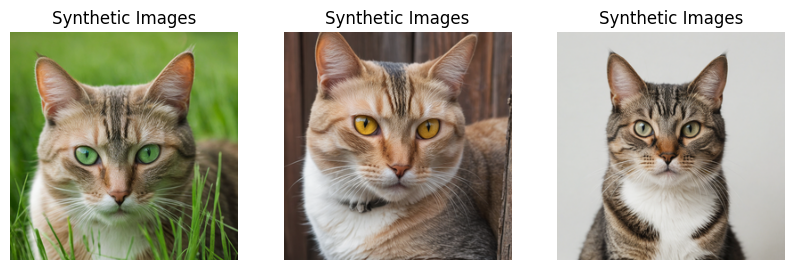

In [3]:
# Explore and visualize some samples
def show_sample_images(dataset, title, num_images=3):
    plt.figure(figsize=(10, 5))
    for i in range(num_images):
        example = dataset[i]
        plt.subplot(1, num_images, i + 1)
        plt.imshow(example["image"])
        plt.axis('off')
        plt.title(title)
    plt.show()

show_sample_images(afhq_dataset["train"], "Real Images")
show_sample_images(afhq_realvisxl_dataset["train"], "Synthetic Images")


In [22]:
# Custom Dataset Class
class ImageDataset(Dataset):
    def __init__(self, dataset, is_synthetic=False):
        self.dataset = dataset
        self.is_synthetic = is_synthetic
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(15),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
            transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image = self.dataset[idx]['image']
        
        # Ensure image is in correct format
        if not isinstance(image, Image.Image):
            image = Image.fromarray(image)
        if image.mode != 'RGB':
            image = image.convert('RGB')
        
        image = self.transform(image)
        label = torch.tensor(1 if self.is_synthetic else 0, dtype=torch.long)
        
        return image, label

In [45]:
class RealFakeDetectorTransferLearning(pl.LightningModule):
    def __init__(self, learning_rate=1e-3, freeze_layers=True, dropout_rate=0.5):
        super().__init__()
        # Load pretrained EfficientNet model
        self.base_model = timm.create_model('efficientnet_b0', pretrained=True)
        
        # Freeze layers if needed
        if freeze_layers:
            for param in self.base_model.parameters():
                param.requires_grad = False
        
        # Replace classifier with custom layers
        num_features = self.base_model.get_classifier().in_features
        self.base_model.classifier = nn.Identity()  # Remove the existing classifier layer
        self.fc1 = nn.Linear(num_features, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 2)
        
        self.criterion = nn.CrossEntropyLoss()
        self.learning_rate = learning_rate

    def forward(self, x):
        x = self.base_model(x)  # Pass through EfficientNet
        x = F.relu(self.fc1(x))  # First custom layer
        x = F.relu(self.fc2(x))  # Second custom layer
        x = self.fc3(x)  # Output layer
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        acc = (y_hat.argmax(dim=1) == y).float().mean()
        self.log('train_loss', loss)
        self.log('train_acc', acc)
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.learning_rate)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, 
            mode='min', 
            factor=0.1, 
            patience=3,
            verbose=True
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "train_loss"
            }
        }

# Instantiate the model
model = RealFakeDetectorTransferLearning()


###  imporved training class generated by cursor 

In [63]:
class RealFakeDetectorTransferLearning(pl.LightningModule):
    def __init__(self, learning_rate=1e-3, freeze_layers=True, dropout_rate=0.5):
        super().__init__()
        # Use EfficientNet-B3 for better feature extraction
        self.base_model = timm.create_model('efficientnet_b3', pretrained=True)
        self.learning_rate = learning_rate
        
        # Freeze EfficientNet layers and set to eval mode
        if freeze_layers:
            self.base_model.eval()  # Set to evaluation mode
            for param in self.base_model.parameters():
                param.requires_grad = False
        
        num_features = self.base_model.get_classifier().in_features
        self.base_model.classifier = nn.Identity()
        
        self.classifier = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(256, 2)
        )
        
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, x):
        with torch.no_grad():  # No gradients needed for frozen base_model
            x = self.base_model(x)
        x = self.classifier(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        
        # Calculate accuracy
        preds = torch.argmax(y_hat, dim=1)
        acc = (preds == y).float().mean()
        
        # Log metrics
        self.log('train_loss', loss, prog_bar=True)
        self.log('train_acc', acc, prog_bar=True)
        
        # Log current learning rate
        current_lr = self.optimizers().param_groups[0]['lr']
        self.log('learning_rate', current_lr, prog_bar=True)
        
        return loss

    def configure_optimizers(self):
        optimizer = optim.AdamW(
            self.parameters(),
            lr=self.learning_rate,
            weight_decay=0.01
        )
        
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode='min',
            factor=0.1,
            patience=3,
            min_lr=1e-6
        )
        
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "train_loss",
                "frequency": 1
            }
        }

 ends here

In [64]:
# Initialize and Combine datasets
train_dataset_real = ImageDataset(afhq_dataset["train"], is_synthetic=False)
train_dataset_synthetic = ImageDataset(afhq_realvisxl_dataset["train"], is_synthetic=True)
train_dataset = ConcatDataset([train_dataset_real, train_dataset_synthetic])


In [65]:
# DataLoader configuration
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=4  # Increase workers for efficiency
)

In [68]:
# Instantiate the model
model = RealFakeDetectorTransferLearning()

# Trainer setup as before
trainer = pl.Trainer(
    max_epochs=1,  # Train for more epochs
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=1,
    callbacks=[
        pl.callbacks.EarlyStopping(
            monitor='train_loss',
            patience=5,
            mode='min'
        ),
        pl.callbacks.ModelCheckpoint(
            monitor='train_loss',
            dirpath='checkpoints',
            filename='best-checkpoint',
            save_top_k=1,
            mode='min'
        )
    ]
)
trainer.fit(model, train_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /teamspace/studios/this_studio/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type             | Params | Mode 
--------------------------------------------------------
0 | base_model | EfficientNet     | 10.7 M | eval 
1 | classifier | Sequential       | 920 K  | train
2 | criterion  | CrossEntropyLoss | 0      | train
--------------------------------------------------------
920 K     Trainable params
10.7 M    Non-trainable params
11.6 M    Total params
46.466    Total estimated model params size (MB)
12        Modules in train mode
532       Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


In [ ]:
# Save and load the model
model_name = "hello.pth"
torch.save(model.state_dict(), model_name)
model = RealFakeDetectorTransferLearning()
model.load_state_dict(torch.load(model_name))
model.eval()

In [75]:
# Save the trained model
torch.save(model.state_dict(), 'real_fake_detector.pth')

# Load the model later
model = RealFakeDetectorTransferLearning()
model.load_state_dict(torch.load('real_fake_detector.pth'))# Set to evaluation mode

<All keys matched successfully>

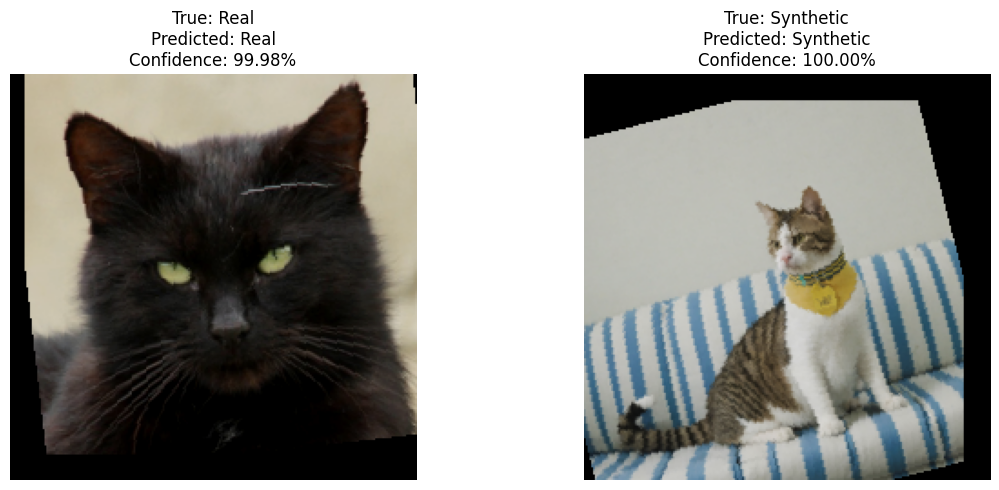


Detailed Predictions:

Real Image:
Raw logits: [4.669566631317139, -3.7837791442871094]
Probabilities: Real: 99.98%, Synthetic: 0.02%

Synthetic Image:
Raw logits: [-6.790366172790527, 6.0114359855651855]
Probabilities: Real: 0.00%, Synthetic: 100.00%


In [77]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import numpy as np

def predict_and_visualize(model, real_dataset, synthetic_dataset, real_idx=0, synthetic_idx=0):
    """
    Predicts and visualizes results for one real and one synthetic image
    """
    # Set model to evaluation mode
    model.eval()
    
    # Get one sample from each dataset
    real_img, _ = real_dataset[real_idx]
    synthetic_img, _ = synthetic_dataset[synthetic_idx]
    
    # Get raw predictions
    with torch.no_grad():
        real_pred = model(real_img.unsqueeze(0))
        synthetic_pred = model(synthetic_img.unsqueeze(0))
        
        # Apply softmax to get probabilities
        real_prob = F.softmax(real_pred, dim=1)
        synthetic_prob = F.softmax(synthetic_pred, dim=1)
        
        # Get confidence scores
        real_conf = real_prob.max().item() * 100
        synthetic_conf = synthetic_prob.max().item() * 100
        
        # Get predicted labels
        real_label = "Real" if real_prob.argmax().item() == 0 else "Synthetic"
        synthetic_label = "Real" if synthetic_prob.argmax().item() == 0 else "Synthetic"

    # Plotting
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Convert tensor to image for visualization
    def tensor_to_img(tensor):
        # Denormalize
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        img = tensor * std + mean
        img = img.permute(1, 2, 0).numpy()
        img = np.clip(img, 0, 1)
        return img
    
    # Plot first image
    ax1.imshow(tensor_to_img(real_img))
    ax1.set_title(f'True: Real\nPredicted: {real_label}\nConfidence: {real_conf:.2f}%')
    ax1.axis('off')
    
    # Plot second image
    ax2.imshow(tensor_to_img(synthetic_img))
    ax2.set_title(f'True: Synthetic\nPredicted: {synthetic_label}\nConfidence: {synthetic_conf:.2f}%')
    ax2.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed predictions
    print("\nDetailed Predictions:")
    print(f"\nReal Image:")
    print(f"Raw logits: {real_pred.squeeze().tolist()}")
    print(f"Probabilities: Real: {real_prob[0][0]*100:.2f}%, Synthetic: {real_prob[0][1]*100:.2f}%")
    print(f"\nSynthetic Image:")
    print(f"Raw logits: {synthetic_pred.squeeze().tolist()}")
    
    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.learning_rate)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, 
            mode='min', 
            factor=0.1, 
            patience=3,
            verbose=True
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "train_loss"
            }
        }
    print(f"Probabilities: Real: {synthetic_prob[0][0]*100:.2f}%, Synthetic: {synthetic_prob[0][1]*100:.2f}%")

# Test the visualization with loaded model and datasets
# predict_and_visualize(loaded_model, train_dataset_real, train_dataset_synthetic)

# You can also try different images by changing the indices:
predict_and_visualize(model, train_dataset_real, train_dataset_synthetic, real_idx=32, synthetic_idx=4)

# applying YOLO v8 CAMO

In [80]:
import torch
from PIL import Image
import torchvision.transforms as transforms
from ultralytics import YOLO  # This will use YOLOv8 by default

# Load your trained model
real_fake_model = RealFakeDetectorTransferLearning()
real_fake_model.load_state_dict(torch.load('real_fake_detector.pth'))
real_fake_model.eval()

# Load YOLO model
yolo_model = YOLO('yolov8n.pt')  # Using the nano version, you can use 's', 'm', or 'l' for larger models

def process_image(image_path):
    """
    Process an image through YOLO and RealFakeDetector if it contains an animal
    """
    # Run YOLO detection
    results = yolo_model(image_path)
    
    # Check if any detected object is an animal
    animal_classes = ['bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe']
    
    is_animal = False
    for result in results:
        for c in result.boxes.cls:
            class_name = result.names[int(c)]
            if class_name.lower() in animal_classes:
                is_animal = True
                break
    
    if not is_animal:
        return "Not an animal image"
    
    # If it's an animal, process through your real/fake detector
    # Prepare image for your model
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])
    ])
    
    # Load and transform image
    img = Image.open(image_path).convert('RGB')
    img_tensor = transform(img).unsqueeze(0)  # Add batch dimension
    
    # Get prediction
    with torch.no_grad():
        output = real_fake_model(img_tensor)
        prediction = torch.argmax(output, dim=1).item()
    
    return "Real animal" if prediction == 0 else "Synthetic/AI-generated animal"

# Test the pipeline
def test_image(image_path):
    print(f"Processing image: {image_path}")
    result = process_image(image_path)
    print(f"Result: {result}")
    
# Example usage
test_image('animal.jpg')

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/teamspace/studios/this_studio/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 6.25M/6.25M [00:00<00:00, 108MB/s]

Processing image: animal.jpg



image 1/1 /teamspace/studios/this_studio/animal.jpg: 576x640 1 bear, 83.4ms
Speed: 2.9ms preprocess, 83.4ms inference, 300.7ms postprocess per image at shape (1, 3, 576, 640)
Result: Synthetic/AI-generated animal


In [82]:
test_image('animal2.jpg')

Processing image: animal2.jpg

image 1/1 /teamspace/studios/this_studio/animal2.jpg: 512x640 1 bear, 84.5ms
Speed: 1.0ms preprocess, 84.5ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)
Result: Real animal


In [84]:
import torch
from PIL import Image
import torchvision.transforms as transforms
from ultralytics import YOLO

# Load your trained model
real_fake_model = RealFakeDetectorTransferLearning()
real_fake_model.load_state_dict(torch.load('real_fake_detector.pth'))
real_fake_model.eval()

# Load YOLO model
yolo_model = YOLO('yolov8n.pt')

def process_image(image_path):
    """
    Process an image through YOLO and RealFakeDetector if it contains an animal
    """
    # Run YOLO detection
    print("Running YOLO model...")
    results = yolo_model(image_path)
    
    # Debug: Print raw YOLO output
    print("Raw YOLO output:")
    print(results)

    # Check if any detected object is an animal
    animal_classes = ['bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe']
    
    is_animal = False
    for result in results:
        for c in result.boxes.cls:
            class_name = result.names[int(c)]
            print(f"Detected class: {class_name}")  # Debug: Print detected class
            if class_name.lower() in animal_classes:
                is_animal = True
                break
    
    if not is_animal:
        return "Not an animal image"
    
    # If it's an animal, process through your real/fake detector
    print("Processing through RealFakeDetector...")
    
    # Prepare image for your model
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize to 224x224
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                             std=[0.229, 0.224, 0.225])
    ])
    
    # Load and transform image
    img = Image.open(image_path).convert('RGB')
    print(f"Original image size: {img.size}")  # Debug: Print original image size
    img_tensor = transform(img).unsqueeze(0)  # Add batch dimension
    print(f"Transformed image tensor shape: {img_tensor.shape}")  # Debug: Print tensor shape

    # Get prediction
    with torch.no_grad():
        output = real_fake_model(img_tensor)
        print("Raw output from RealFakeDetector:")
        print(output)  # Debug: Print raw output from the model
        
        prediction = torch.argmax(output, dim=1).item()
    
    return "Real animal" if prediction == 0 else "Synthetic/AI-generated animal"

# Test the pipeline
def test_image(image_path):
    print(f"Processing image: {image_path}")
    result = process_image(image_path)
    print(f"Result: {result}")

# Example usage
test_image('animal2.jpg')

Processing image: animal2.jpg
Running YOLO model...

image 1/1 /teamspace/studios/this_studio/animal2.jpg: 512x640 1 bear, 6.4ms
Speed: 0.7ms preprocess, 6.4ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Raw YOLO output:
[ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 5